<a href="https://colab.research.google.com/github/FlintyTub49/DL-Sem-VI/blob/main/Experiment%209/Facial%20Key%20Point%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Loading The Data

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mjhp6dyuY5cIt78yX4VqIhBn6322FMD7' -O KeyFacialPoints.csv
facialpoints_df = pd.read_csv('KeyFacialPoints.csv')
facialpoints_df.head()

--2021-03-29 10:44:50--  https://docs.google.com/uc?export=download&id=1mjhp6dyuY5cIt78yX4VqIhBn6322FMD7
Resolving docs.google.com (docs.google.com)... 74.125.20.100, 74.125.20.113, 74.125.20.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4aot7g0i2kpkg0amqahln02ci147lucq/1617014625000/17242455652310080862/*/1mjhp6dyuY5cIt78yX4VqIhBn6322FMD7?e=download [following]
--2021-03-29 10:44:54--  https://doc-08-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4aot7g0i2kpkg0amqahln02ci147lucq/1617014625000/17242455652310080862/*/1mjhp6dyuY5cIt78yX4VqIhBn6322FMD7?e=download
Resolving doc-08-7s-docs.googleusercontent.com (doc-08-7s-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-08-7s-docs.googleusercontent.com (doc-08-7s-docs.

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [3]:
facialpoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

### Checking Size and Null Values

In [4]:
facialpoints_df['Image'] = facialpoints_df['Image'].apply(
    lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96, 96))

print('Dataset Size', facialpoints_df['Image'][1].shape)
facialpoints_df.isnull().sum()

Dataset Size (96, 96)


left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

## Visualizations

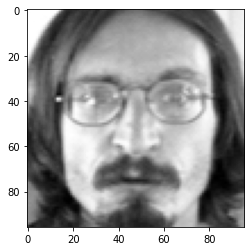

In [5]:
# Plot a random image from the dataset along with facial keypoints. 
i = np.random.randint(1, len(facialpoints_df))
plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')

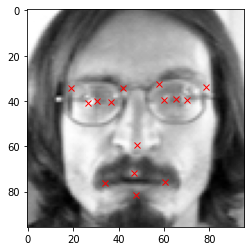

In [6]:
plt.figure()
plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

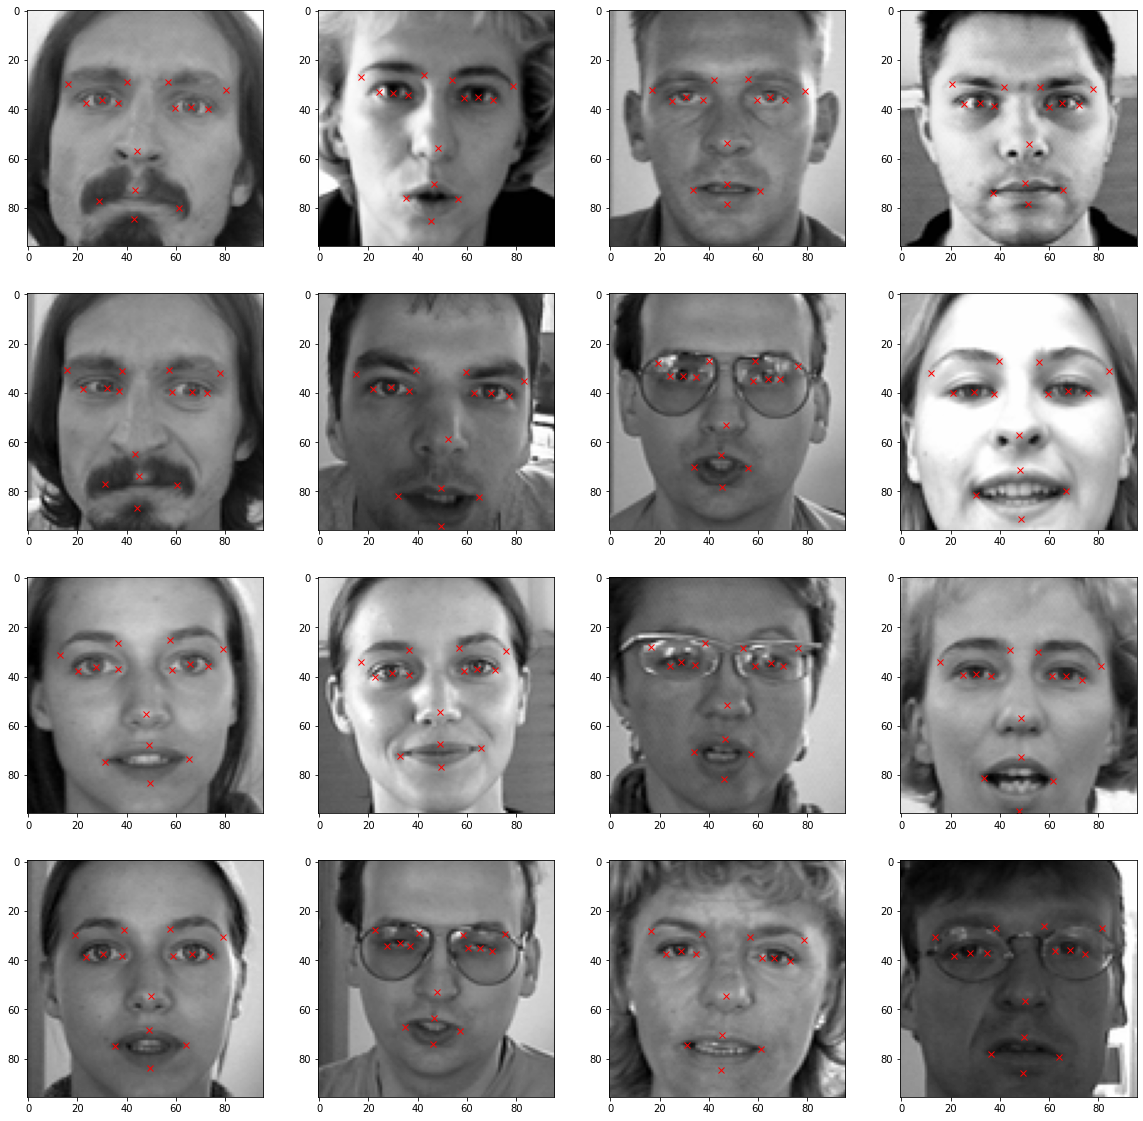

In [7]:
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

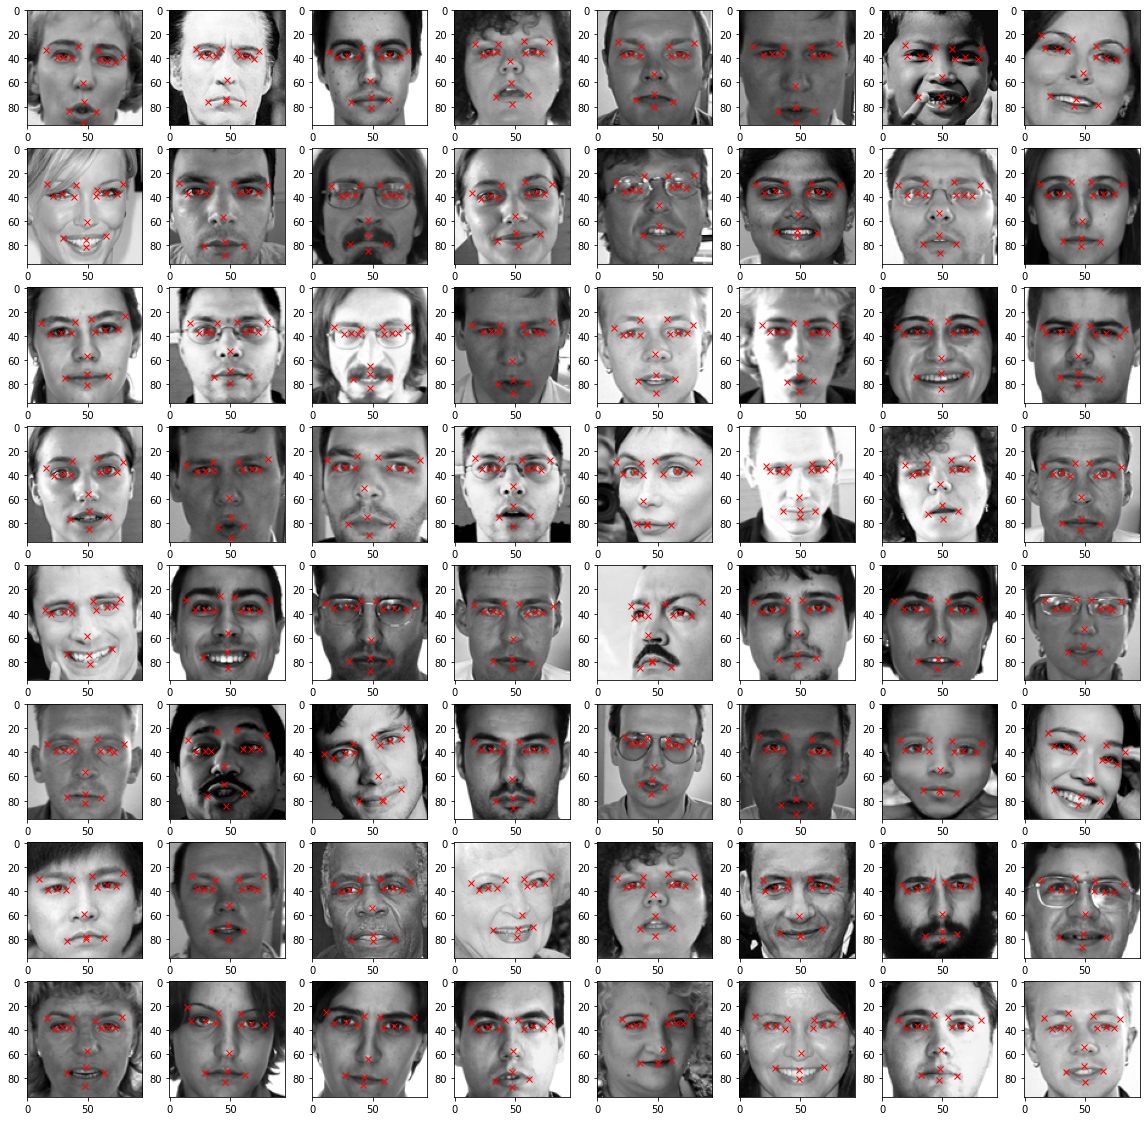

In [8]:
fig = plt.figure(figsize = (20, 20))

for i in range(64):
    img = np.random.randint(1, len(facialpoints_df))
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(facialpoints_df['Image'][img], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[img][j-1], facialpoints_df.loc[img][j], 'rx')

## Image Augmentation

### Getting Columns

In [9]:
facialpoints_df_copy = facialpoints_df.copy()

columns = facialpoints_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

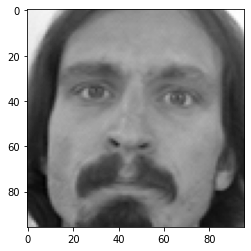

In [10]:
# plot the sample image
plt.imshow(facialpoints_df['Image'][0], cmap = 'gray')

In [11]:
# Now Let's flip the image column horizontally 
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

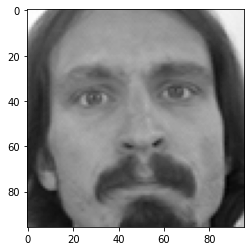

In [12]:
# Notice that the image is flipped now
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')

### Horizontally Flipping Images

In [13]:
for i in range(len(columns)):
  if i%2 == 0:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x))

facialpoints_df_augmented = np.concatenate((facialpoints_df,facialpoints_df_copy))
facialpoints_df_augmented.shape

(4280, 31)

### Randomly Increasing Brightness Of Images

In [15]:
facialpoints_df_copy = facialpoints_df.copy()
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(
    lambda x:np.clip(random.uniform(1, 2) * x, 0.0, 255.0))

facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(6420, 31)

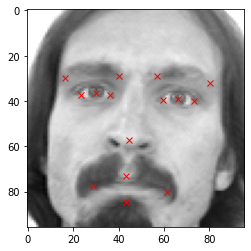

In [16]:
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j - 1], facialpoints_df_copy.loc[0][j], 'rx')

### Flipping Images Vertically

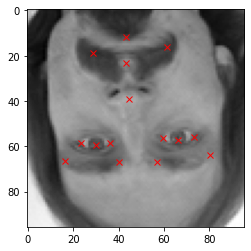

In [17]:
facialpoints_df_copy = facialpoints_df.copy()

# Flip the image column vertically (note that axis = 0) 
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

for i in range(len(columns)):
  if i%2 == 1:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )
    
# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [18]:
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(8560, 31)

## Data Preparation

### Making X

In [19]:
# Normalizing The Images
img = facialpoints_df_augmented[:, 30]
img = img / 255.

# Create an empty array of shape (8560, 96, 96, 1) to train the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the normalized images list and add image values to the empty array 
# Note that we need to expand it's dimension from (96,96) to (96,96,1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

### Making Y

In [20]:
# Obtain the values of key face points coordinates, which are to used as target.
y = facialpoints_df_augmented[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [21]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7704, 96, 96, 1), (856, 96, 96, 1), (7704, 30), (856, 30))

## Modelling

### Making Residual Network Block

In [23]:
def res_block(X, filter, stage):
    
  # CONVOLUTIONAL BLOCK
  X_copy = X
  f1 , f2, f3 = filter

  # Main Path
  #Layer L+1
  X = Conv2D(f1, (1,1), strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  #Layer L+2
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  #Layer L+3
  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Add data from main and short paths
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
  # IDENTITY BLOCK 1
  X_copy = X
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
  # IDENTITY BLOCK 2
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [24]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Stage #1
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# Stage #2
X = res_block(X, filter= [64, 64, 256], stage = 2)

# Stage #3
X = res_block(X, filter= [128, 128, 512], stage = 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model(inputs = X_input, outputs = X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

## Compiling And Running The Model

### Compiling

In [25]:
adam = tf.keras.optimizers.Adam(lr = 0.001, beta_1 =0.9, beta_2 = 0.999, amsgrad =False)
model.compile(loss = "mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [26]:
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only = True)
history = model.fit(X_train, y_train, batch_size = 256, epochs = 100, 
                    validation_split = 0.05, callbacks = [checkpointer])

Epoch 1/100
29/29 [==============================] - 40s 167ms/step - loss: 878.8657 - accuracy: 0.1718 - val_loss: 2161.5078 - val_accuracy: 0.3782

Epoch 00001: val_loss improved from inf to 2161.50781, saving model to weights.hdf5
Epoch 2/100
29/29 [==============================] - 3s 114ms/step - loss: 161.9970 - accuracy: 0.6765 - val_loss: 1789.8191 - val_accuracy: 0.3782

Epoch 00002: val_loss improved from 2161.50781 to 1789.81909, saving model to weights.hdf5
Epoch 3/100
29/29 [==============================] - 3s 114ms/step - loss: 108.8380 - accuracy: 0.6954 - val_loss: 1467.2297 - val_accuracy: 0.3782

Epoch 00003: val_loss improved from 1789.81909 to 1467.22974, saving model to weights.hdf5
Epoch 4/100
29/29 [==============================] - 3s 116ms/step - loss: 74.0050 - accuracy: 0.7010 - val_loss: 1197.5525 - val_accuracy: 0.3782

Epoch 00004: val_loss improved from 1467.22974 to 1197.55249, saving model to weights.hdf5
Epoch 5/100
29/29 [============================

### Saving The Model

In [27]:
# Save trained model
model_json = model.to_json()
with open('KeyPointDetector.json', 'w') as json_file:
        json_file.write(model_json)

## Evaluating Model Performance

### Loading The Model

In [28]:
# instead of training from scratch, you can load trained model weights
with open('KeyPointDetector.json', 'r') as json_file:
    json_SavedModel = json_file.read()
    
model = tf.keras.models.model_from_json(json_SavedModel)
model.load_weights('weights.hdf5')
model.compile(loss = "mean_squared_error", optimizer = adam, metrics = ['accuracy'])

### Retraining The Model

In [29]:
# saving the model in tensorflow format
model.save('./MyModel_tf', save_format='tf')

# loading the saved model
loaded_model = tf.keras.models.load_model('./MyModel_tf')

# retraining the model
loaded_model.fit(X_train, y_train, batch_size = 256, epochs = 100, 
                 validation_split = 0.05, callbacks = [checkpointer])

INFO:tensorflow:Assets written to: ./MyModel_tf/assets
Epoch 1/100
29/29 [==============================] - 6s 130ms/step - loss: 197.0001 - accuracy: 0.7186 - val_loss: 118.0097 - val_accuracy: 0.6140

Epoch 00001: val_loss did not improve from 30.54008
Epoch 2/100
29/29 [==============================] - 3s 116ms/step - loss: 13.7088 - accuracy: 0.7234 - val_loss: 51.8064 - val_accuracy: 0.7824

Epoch 00002: val_loss did not improve from 30.54008
Epoch 3/100
29/29 [==============================] - 3s 116ms/step - loss: 9.4857 - accuracy: 0.7465 - val_loss: 39.5945 - val_accuracy: 0.7902

Epoch 00003: val_loss did not improve from 30.54008
Epoch 4/100
29/29 [==============================] - 3s 116ms/step - loss: 8.2533 - accuracy: 0.7652 - val_loss: 35.1789 - val_accuracy: 0.7850

Epoch 00004: val_loss did not improve from 30.54008
Epoch 5/100
29/29 [==============================] - 3s 117ms/step - loss: 7.4533 - accuracy: 0.7688 - val_loss: 32.5273 - val_accuracy: 0.7850

Epoch 00

### Checking On Test Set

In [30]:
# Evaluate trained model
result = model.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

27/27 [==============================] - 1s 13ms/step - loss: 27.5766 - accuracy: 0.8149
Accuracy : 0.822429895401001


In [31]:
# Make prediction using the testing dataset
df_predict = model.predict(X_test)

In [32]:
# Print the rmse loss values

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, df_predict))
print("RMSE value : {}".format(rms))

RMSE value : 5.468688092562544


### Plotting Predicted Data Points

In [33]:
df_predict= pd.DataFrame(df_predict, columns = columns)
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,65.417603,38.007034,28.740536,39.243256,59.234337,38.792862,71.728096,38.664215,34.740955,39.321495,22.989243,40.305027,55.221554,29.920481,77.822716,30.182608,36.430447,30.512262,16.003567,32.534008,46.519398,53.410156,63.521927,74.943321,34.400555,76.204971,48.061134,68.918266,48.432457,83.965401
1,65.509964,36.615696,29.364601,34.862095,58.692501,37.308308,72.933098,37.666973,36.827019,36.086357,21.959604,35.418934,56.331871,28.009706,79.875381,29.746477,41.331070,26.867550,15.090661,27.261290,49.278393,56.828697,60.408112,76.799355,31.614569,75.898605,46.968994,72.989784,46.769005,81.891022
2,29.181538,34.686199,65.546967,35.478512,35.716900,35.474045,22.320486,35.329979,58.530354,35.931679,72.770348,36.632317,37.672058,26.581244,16.739941,27.442410,55.904903,26.865587,79.365868,29.301119,45.115646,50.461960,30.828035,70.575783,62.347462,71.313072,45.981396,65.686150,45.880585,78.641121
3,31.411913,38.054314,68.204269,40.563858,37.591682,38.698528,25.255030,38.209908,61.937962,40.308510,74.567780,42.094963,40.781910,29.984350,19.742119,29.691910,60.501244,31.572834,81.494049,34.858612,48.874233,50.876068,32.235050,75.212242,61.530506,77.612473,47.431660,68.446777,46.718029,83.289551
4,66.885017,37.371708,29.055145,36.113914,58.496151,38.612656,75.955605,38.123814,36.799084,37.786980,20.487169,36.477772,54.157223,31.813923,82.517265,30.449245,38.080414,31.639040,14.357410,28.759743,43.275131,61.982914,64.769249,75.092369,29.549034,74.170151,45.619011,76.654030,45.543560,80.757378


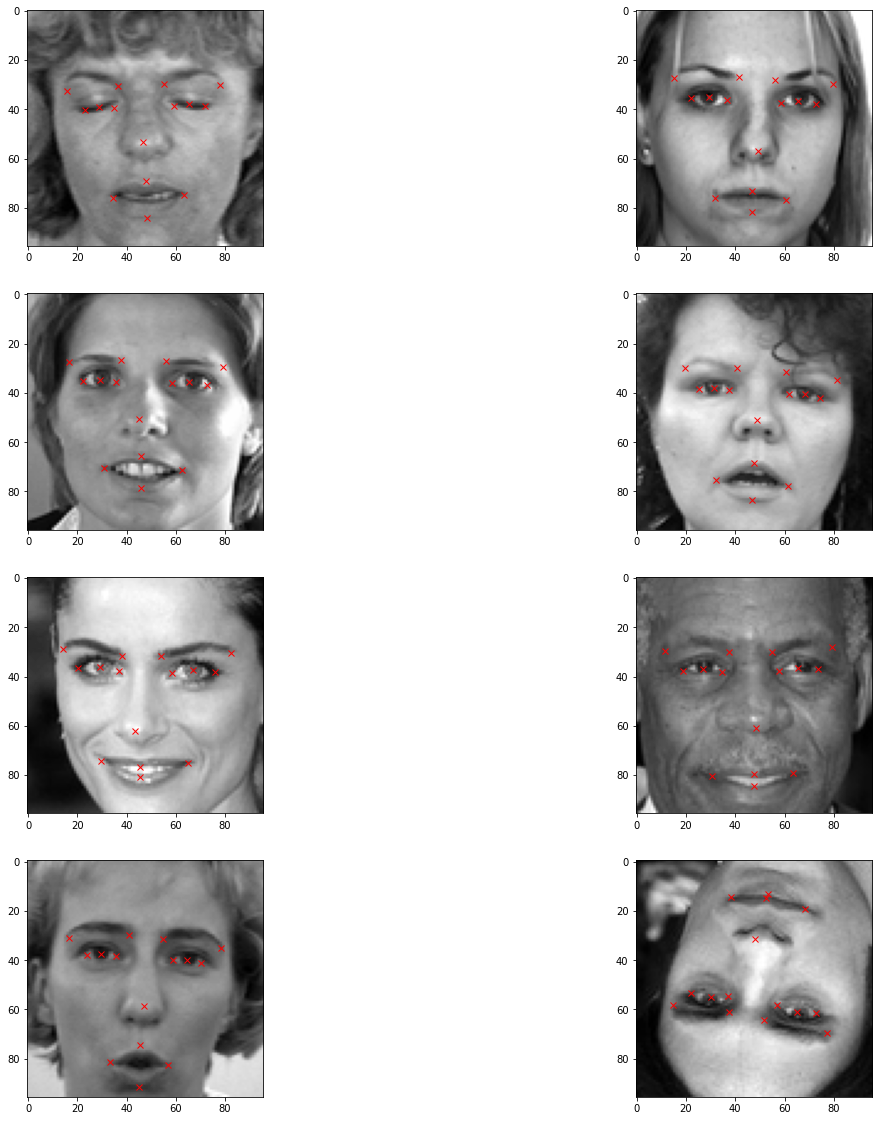

In [34]:
# Plot the test images and their predicted keypoints

fig = plt.figure(figsize=(20, 20))

for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # Using squeeze to convert the image shape from (96,96,1) to (96,96)
    plt.imshow(X_test[i].squeeze(),cmap='gray')
    for j in range(1,31,2):
            plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')